# <font color='#03A9F4'>Network analysis</font>

Neworks are everywhere! We networks of roads, networks of friends and followers on social media, biological networks, food webs, <!--vocabulary networks in literature,-->the world wide web. Play a useful role in disseminating information. The ability to analyse and make informed decisons using networks is an important skill for a data scientist. Network analysis involves modeling datasets as a network to emphasize, reveal or reflect relationships or connections (called edges) between components or entities (called nodes).

<table bgcolor="white">
    <tr>
        <td> <img src="roadnetwork.jpg" alt="road" style="lenght: 200px;"/> </td>
        <td> <img src="socialnetwork.png" alt="Drawing" style="length: 250px;"/> </td>
    </tr>
    <tr>
        <td> <img src="neuron.png" alt="road" style="lenght: 50px;"/> </td>
        <td> <img src="foodweb.png" alt="Drawing" style="length: 50px;"/> </td>
    </tr>
    <tr>
        <td> <img src="pagerank.png" alt="road" style="lenght: 50px;"/> </td>
        <td> <img src="graph_labelled.png" alt="Drawing" style="length: 50px;"/> </td>
    </tr>
</table>

In [2]:
import os
import pickle
import tweepy as tw
import pandas as pd
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import re
import nltk
from nltk import bigrams
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

## <font color='#03A9F4'>Example 1: Analysing Twitter data</font>

### Retrieve stored tweets

Helper functions to clean up tweets, store them on local drive for later use.

In [3]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [4]:
def store_tweets(data):
    file = open('tweets.pkl', 'wb')
    pickle.dump(data, file)
    file.close()

Upload file with saved tweets

In [6]:
all_tweets = pd.read_pickle('tweets.pkl'); all_tweets[:5]

['Surprised Priti Patel hasn’t released a critical statement about the increasing number of journalists and TV crews… https://t.co/KbyQAPlpQM',
 'FYI for OC: Restaurants can now apply for relief grants to reimburse purchases of PPE, cleaning supplies, employee… https://t.co/f8pL4z8h8T',
 'Media24 partners with eComplete to put your business on the map for e-commerce! https://t.co/MQ8ASLerD0 | @media24… https://t.co/7JAK8yaonB',
 "Masking up in LAGBAJA'S Style...Fashion has no limit. Keeping safe is the goal! \n\n#keepsafe #covid19 #facemask… https://t.co/Hc6hnzjKsd",
 'WATCH LIVE: MPs and federal health officials update the coronavirus https://t.co/cMZi720vDM #cdnpoli #coronavirus #covid19']

### Clean tweets

Do some natural language processing:

    remove URLs from tweets
    
    turn tweets to lowercase
    
    remove stop words

In [8]:
# remove URLs
tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]

# create a sublist of lower case words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]

# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]


# remove collection words or words that could skew frequency analysis
collection_words = ['everything', 'today']

tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

[nltk_data] Downloading package stopwords to /home/ndeyak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word frequency analysis

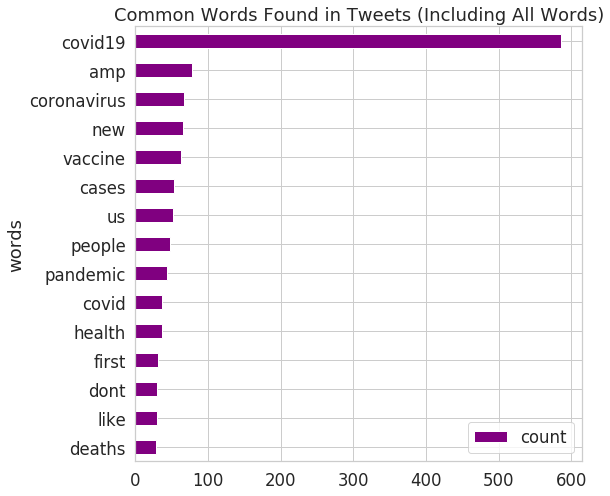

In [9]:
# flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))

# create counter
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

clean_tweets_nsw_nc = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])


fig, ax = plt.subplots(figsize=(8, 8))

# plot horizontal bar graph
clean_tweets_nsw_nc.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)");




### Visualing bigrams

Explore Co-occurring Words (Bigrams)

To identify co-occurrence of words in the tweets, you can use bigrams from nltk.

Begin with a list comprehension to create a list of all bigrams (i.e. co-occurring words) in the tweets.

Display network of co-occurring words

In [10]:
# create list of lists containing bigrams in tweets
terms_bigram = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_nc]

# flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

bigram  count
0       (covid19, vaccine)     30
1      (covid19, pandemic)     17
2         (covid19, cases)     13
3             (new, cases)     12
4   (covid19, coronavirus)     12
5   (coronavirus, covid19)     11
6           (due, covid19)     11
7         (fight, covid19)     10
8         (first, covid19)     10
9               (join, us)      9
10       (impact, covid19)      8
11       (spread, covid19)      8
12            (wear, mask)      8
13        (covid, covid19)      7
14       (covid19, deaths)      7
15     (russia, registers)      7
16      (covid19, testing)      7
17        (covid19, covid)      6
18       (covid19, relief)      6
19        (mental, health)      6

(-0.9151599197889257,
 1.1047474448941257,
 -0.8628345903658525,
 1.0291691833165253)

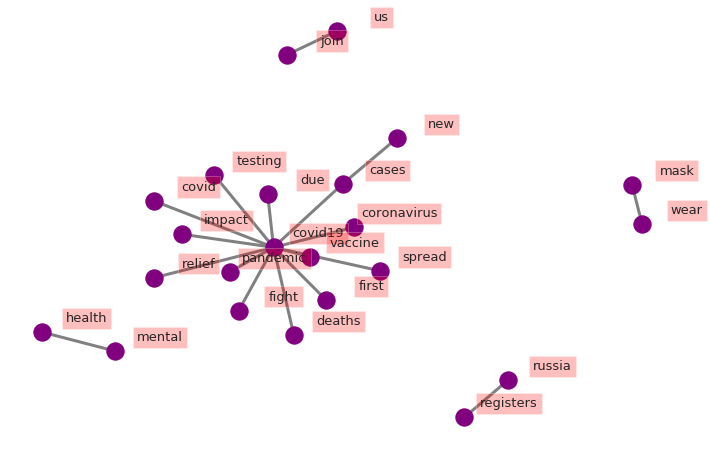

In [11]:
# create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# create network plot 
G = nx.Graph()

# create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("cases", weight=100)
fig, ax = plt.subplots(figsize=(12,8))

pos = nx.spring_layout(G, k=2)

# plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.axis('off')

See the networks of co-occurring words in tweets on covid19.

## <font color='#03A9F4'>Example 2: Analysing Facebook data</font>

Visualise social network dataset, [Facebook combined ego networks dataset](https://snap.stanford.edu/data/egonets-Facebook.html), which contains the aggregated network of ten individuals' Facebook friends list. 

In [12]:
fbgraph = nx.read_edgelist("facebook_combined.txt", 
                      create_using = nx.Graph(), 
                      nodetype=int)
print(nx.info(fbgraph))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


### <font color='#03A9F4'>Network influencers</font>

Now if you want to find out who the influencers are in this network (the most important nodes), there are several metrics to quantify this property. They are called centrality measures and they can help us in identifying popularity, most liked, and biggest influencers within the network.

#### Betweenness Centrality

The betweenness of a node is the number of shortest paths between all possible pairs of nodes in the network that traverse the node.

We can also visualize the network such that the node color varies with Degree and node size with Betweenness Centrality

In [ ]:
pos = nx.spring_layout(fbgraph)
betCent = nx.betweenness_centrality(fbgraph, normalized=True, endpoints=True)
node_color = [20000.0 * fbgraph.degree(v) for v in fbgraph]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(fbgraph, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

Which nodes have the highest Betweeness Centrality?

In [ ]:
between = sorted(betCent, key=betCent.get, reverse=True)[:5]

#### Eigenvector Centrality

[Google's PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm uses Eigenvector Centrality.

(-0.8893205767671911,
 1.0606010833554875,
 -1.0812251850645151,
 0.7057286306889701)

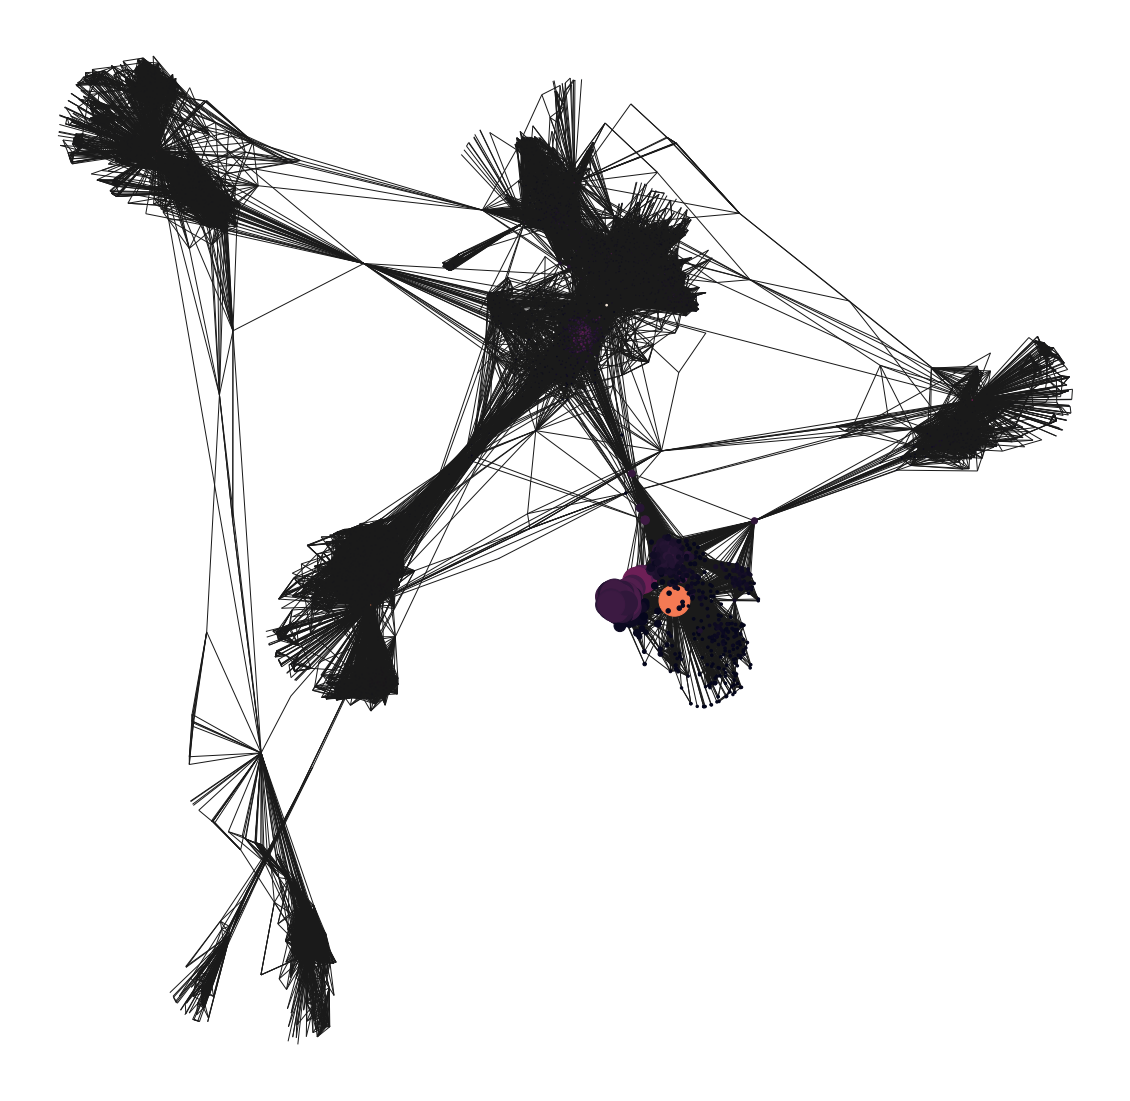

In [9]:
pos = nx.spring_layout(fbgraph)
eigCent = nx.eigenvector_centrality(fbgraph)
node_color = [20000.0 * fbgraph.degree(v) for v in fbgraph]
node_size =  [v * 10000 for v in eigCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(fbgraph, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [10]:
eigen = sorted(eigCent, key=eigCent.get, reverse=True)[:5]

#### Degree Centrality

Maximal number of connections

(-0.7539984328367998,
 1.0448792130765618,
 -1.0098180123235432,
 1.0972220091920621)

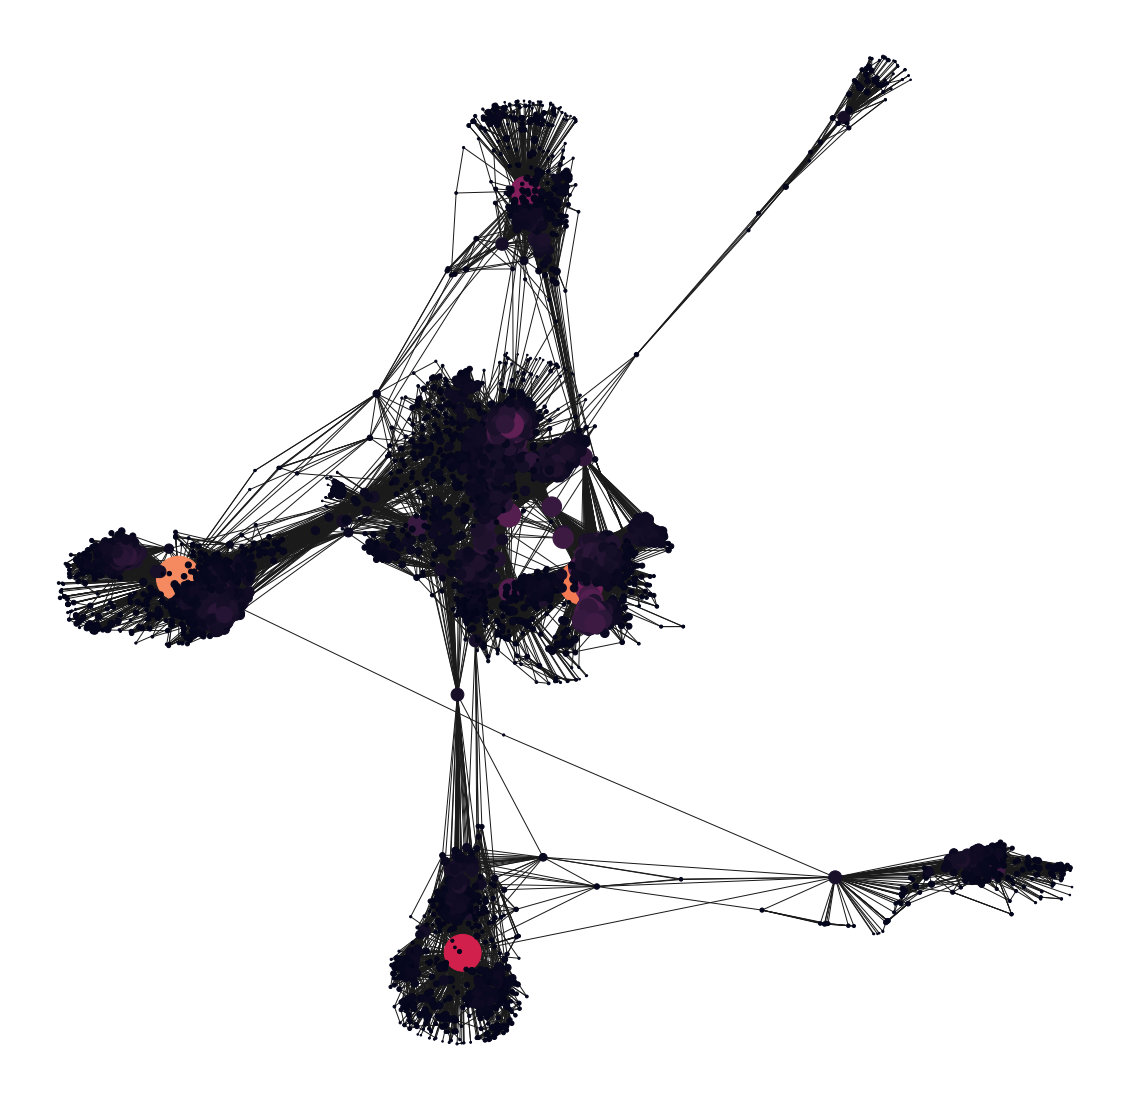

In [11]:
pos = nx.spring_layout(fbgraph)
degCent = nx.degree_centrality(fbgraph)
node_color = [20000.0 * fbgraph.degree(v) for v in fbgraph]
node_size =  [v * 10000 for v in degCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(fbgraph, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [12]:
degree = sorted(degCent, key=degCent.get, reverse=True)[:5]

In [13]:
df = pd.DataFrame({'Betweenness Centrality': between, 
                   'Eigenvector Centrality': eigen, 
                   'Degree Centrality' : degree})

In [14]:
df

Betweenness Centrality  Eigenvector Centrality  Degree Centrality
0                     107                    1912                107
1                    1684                    2266               1684
2                    3437                    2206               1912
3                    1912                    2233               3437
4                    1085                    2464                  0

We can see that some nodes are common between Degree Centrality, which is a measure of edges from a node, and Betweenness Centrality which controls the information flow. It is natural that nodes that are more connected also lie on shortest paths between other nodes. The node `1912` is an important node as it is crucial according to all three centrality measures that we had considered.

# <font color='#03A9F4'>References</font>


https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

https://www.datacamp.com/community/tutorials/social-network-analysis-python

https://link.springer.com/content/pdf/10.1140/epjb/e2015-50671-y.pdf

http://brandonrose.org/ner2sna

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220061